In [1]:
import numpy as np
from time import gmtime, strftime
import pandas as pd
import dataclasses

# Logger and Buffers

In [2]:
class Logger:
    SOURCE_TASK = 'source'
    TARGET_TASK = 'target'
    
    HEADERS = ['task_id', 'reward', 'step', 'accum_loss', 'q_loss', 'psi_loss', 'phi_loss']
    
    def __init__(self, root_path):
        self.source_tasks_file = root_path + f'results/source_performance_{strftime("%d_%b_%Y_%H_%M_%S", gmtime())}.csv'
        self.target_tasks_file = root_path + f'results/target_performance_{strftime("%d_%b_%Y_%H_%M_%S", gmtime())}.csv'
        
    def log_agent_performance(self, task, reward, step, accum_loss, *args, **kwargs):
        values = np.array([task, reward, step, accum_loss, *args])
        type_task = kwargs.get('type_task', self.SOURCE_TASK)
        filename = self.source_tasks_file if type_task == self.SOURCE_TASK else self.target_tasks_file
        
        with open(filename, 'a') as f:
            np.savetxt(f, np.column_stack(values), delimiter=',', newline='\n')
    
    def load_text(self, type_task='source'):
        filename = self.source_tasks_file if type_task == self.SOURCE_TASK else self.target_tasks_file
        
        return pd.DataFrame(np.loadtxt(filename, delimiter=','))

In [3]:
to_tensor = lambda x: torch.tensor(x, device=device, dtype=torch.float32) if not isinstance(x, torch.Tensor) else x

In [4]:
import torch
import numpy as np
import random
import torch.functional as F


device = 'cuda:0'

In [5]:
from collections import deque

class ReplayBuffer:
    
    def __init__(self, config):
        self.n_samples = config.n_replay_samples
        self.n_batch = config.batch_size
        
        # When initialize run reset()
        self.reset()
    
    def reset(self):
        self.buffer = np.empty(self.n_samples, dtype=object)
        self.index = 0
        self.size = 0
    
    def replay(self):
        """
        Samples a batch of samples from the buffer randomly. If the number of samples
        currently in the buffer is less than the batch size, returns None.
        
        Returns
        -------
        states : torch.Tensor
            a collection of starting states of shape [n_batch, -1]
        actions : torch.Tensor
            a collection of actions taken in the starting states of shape [n_batch,]
        rewards : torch.Tensor:
            a collection of rewards (for DQN) or features (for SFDQN) obtained of shape [n_batch, -1]
        next_states : torch.Tensor
            a collection of successor states of shape [n_batch, -1]
        gammas : torch.Tensor
            a collection of discount factors to be applied in computing targets for training of shape [n_batch,]
        """
        if self.size < self.n_batch: return None

        indices = np.random.randint(low=0, high=self.size, size=(self.n_batch,))
        states, actions, rewards, next_states, gammas, masks, phis = zip(*self.buffer[indices])
        
        states = torch.vstack(states)
        actions = np.vstack(actions) # No need to be a tensor
        rewards = torch.vstack(rewards)
        phis = np.vstack(phis) # no need to be a tensor
        next_states = torch.vstack(next_states)
        gammas = torch.vstack(gammas)
        masks = torch.vstack(masks)
        return states, actions, rewards, next_states, gammas, masks, phis
    
    def append(self, state, action, reward, next_state, gamma, mask, phi):
        # Reward are double. Here we convert to float to store float in Buffer
        self.buffer[self.index] = (state, action, reward, next_state, gamma, mask, phi)
        self.size = min(self.size + 1, self.n_samples)
        self.index = (self.index + 1) % self.n_samples
        
class NStepQLearningMemory:
    
    def __init__(self, config):
        self.n_samples = config.n_replay_samples
        self.n_batch = config.batch_size
        self.n_step_q_learning = config.n_step_q_learning
        self.gamma = config.gamma # This is to compute rewards
        
        # When initialize run reset()
        self.reset()
    
    def reset(self):
        self.buffer = np.empty(self.n_samples, dtype=object)
        self.index = 0
        self.size = 0
        
        self._n_step_buffer = deque(maxlen=self.n_step_q_learning)
    
    def replay(self):
        """
        Samples a batch of samples from the buffer randomly. If the number of samples
        currently in the buffer is less than the batch size, returns None.
        
        Returns
        -------
        states : torch.Tensor
            a collection of starting states of shape [n_batch, -1]
        actions : torch.Tensor
            a collection of actions taken in the starting states of shape [n_batch,]
        rewards : torch.Tensor:
            a collection of rewards (for DQN) or features (for SFDQN) obtained of shape [n_batch, -1]
        next_states : torch.Tensor
            a collection of successor states of shape [n_batch, -1]
        gammas : torch.Tensor
            a collection of discount factors to be applied in computing targets for training of shape [n_batch,]
        """
        if self.size < self.n_batch: return None
    
        indices = np.random.choice(self.size, self.n_batch, replace=False)
        # indices = np.random.randint(low=0, high=self.size, size=(self.n_batch,))
        states, actions, rewards, next_states, gammas, masks, phis = zip(*self.buffer[indices])
        
        states = torch.vstack(states)
        actions = np.vstack(actions) # No need to be a tensor
        rewards = torch.vstack(rewards)
        phis = np.vstack(phis) # no need to be a tensor
        next_states = torch.vstack(next_states)
        gammas = torch.vstack(gammas)
        masks = torch.vstack(masks)
        
        return states, actions, rewards, next_states, gammas, masks, phis
        
    def append(self, state, action, reward, next_state, gamma, mask, phi):
        # compute n_step return
        self._n_step_buffer.append((state, action, reward, next_state, gamma, mask, phi))
        
        if len(self._n_step_buffer) == self.n_step_q_learning:
            n_step_reward = torch.tensor([0], dtype=torch.float32, device=device)
            
            # override states before append to replay buffer
            first_state, first_action, *_ = self._n_step_buffer[0]
            _, _, _, n_last_state, _, last_mask, _  = self._n_step_buffer[-1]
            
            for i in reversed(range(len(self._n_step_buffer) - 1)): # Reverse without last state
                _, hidden_action, reward, next_hidden_state, gamma, mask, *_ = self._n_step_buffer[i]
                i_tensor = to_tensor(i)
                n_step_reward += (1 - mask) * (reward * (to_tensor(gamma) ** i_tensor))
                
                if mask:
                    last_mask = mask
                    n_last_state = next_hidden_state
            
            # Reward are double. Here we convert to float to store float in Buffer
            self.buffer[self.index] = (first_state, first_action, n_step_reward, n_last_state, gamma, last_mask, phi)
            self.size = min(self.size + 1, self.n_samples)
            self.index = (self.index + 1) % self.n_samples
            
class RecurrentNStepQLearningMemory:
    
    def __init__(self, config):
        self.n_samples = config.n_replay_samples
        self.n_batch = config.batch_size
        self.n_step_q_learning = config.n_step_q_learning
        self.gamma = config.gamma # This is to compute rewards
        
        self.trace_length = config.trace_length # This is the trace length or the sequence size/length
        self.overlap_size = config.overlap_length # This is the overlap betweeen trance lengths
        
        # When initialize run reset()
        self.reset()
    
    def reset(self):       
        self._n_step_buffer = deque(maxlen=self.n_step_q_learning)
        
        self._hidden_buffer = np.empty(self.trace_length, dtype=object)
        self._hidden_index = 0
        
        self._trace_buffer = np.empty(self.trace_length, dtype=object)
        self._trace_index = 0
        
        
        self.buffer = np.empty(self.n_samples, dtype=object)
        self.index = 0
        self.size = 0
    
    def replay(self):
        """
        Samples a batch of samples from the buffer randomly. If the number of samples
        currently in the buffer is less than the batch size, returns None.
        
        Returns
        -------
        states : torch.Tensor
            a collection of starting states of shape [n_batch, -1]
        actions : torch.Tensor
            a collection of actions taken in the starting states of shape [n_batch,]
        rewards : torch.Tensor:
            a collection of rewards (for DQN) or features (for SFDQN) obtained of shape [n_batch, -1]
        next_states : torch.Tensor
            a collection of successor states of shape [n_batch, -1]
        gammas : torch.Tensor
            a collection of discount factors to be applied in computing targets for training of shape [n_batch,]
        """
        if self.size < self.n_batch: return None
    
        indices = np.random.choice(self.size, self.n_batch, replace=False)
        # indices = np.random.randint(low=0, high=self.size, size=(self.n_batch,))        
        # s, a, r, s1, gamma, masks, _ = zip(*self.buffer[indices])
        
        buffer_replay = self.buffer[indices]

        # actions = np.vstack(actions) # No need to be a tensor
        # phis = np.vstack(phis) # no need to be a tensor
        
        states = None
        actions = None
        rewards = None
        next_states = None
        gammas = None
        masks = None
        phis = None

        for i in range(buffer_replay.shape[0]):
            s, a, r, s1, gamma, mask, phi = zip(*buffer_replay[i])
            s = torch.unsqueeze(torch.vstack(s), dim=0)
            a = np.expand_dims(np.vstack(a), axis=0)
            r = torch.unsqueeze(torch.vstack(r), dim=0)
            s1 = torch.unsqueeze(torch.vstack(s1), dim=0)
            mask = torch.unsqueeze(torch.vstack(mask), dim=0)
            gamma = torch.unsqueeze(torch.vstack(gamma), dim=0)
            phi = torch.unsqueeze(torch.vstack(phi), dim=0)

            if states is None:
                states = s
                actions = a
                rewards = r
                next_states = s1
                gammas = gamma
                masks = mask
                phis = phi
            else:
                states = torch.vstack([states, s])
                actions = np.vstack([actions, a])
                rewards = torch.vstack([rewards, r])
                next_states = torch.vstack([next_states, s1])
                gammas = torch.vstack([gammas, gamma])
                masks = torch.vstack([masks, mask])
                phis = torch.vstack([phis, phi])
        
        return states, actions, rewards, next_states, gammas, masks, phis
        
    def append(self, state, action, reward, next_state, gamma, mask, phi):
        # compute n_step return
        self._n_step_buffer.append((state, action, reward, next_state, gamma, mask, phi))
        
        # If no sufficient buffer transitions
        if len(self._n_step_buffer) < self.n_step_q_learning:
            return
            
        n_step_reward = torch.tensor([0], dtype=torch.float32, device=device)

        # Compute the proper buffers for the n_step_buffer
        first_state, first_action, _, next_state, *_ = self._n_step_buffer[0]
        
        last_mask = torch.tensor(0).to(device) # By default is not finished transition

        for i in reversed(range(len(self._n_step_buffer))): # Reverse without last state
            _, hidden_action, reward, next_hidden_state, gamma, mask, *_ = self._n_step_buffer[i]
            i_tensor = to_tensor(i)
            n_step_reward += (1 - mask) * (reward * (to_tensor(gamma) ** i_tensor))

            if mask:
                last_mask = mask
        
        
        # Store the buffers in the hidden buffer
        
        self._hidden_buffer[self._hidden_index] = (first_state, first_action, n_step_reward, next_state, gamma, last_mask, phi)
        self._hidden_index += 1
        
        # Store hidden buffer into main buffer
        if self._hidden_index % self.trace_length == 0:
            # Reward are double. Here we convert to float to store float in Buffer
            self.buffer[self.index] =  self._hidden_buffer.copy() # Store the first transition
            self.size = min(self.size + 1, self.n_samples)
            self.index = (self.index + 1) % self.n_samples
            
            self._hidden_index = 0

# Config

In [6]:
from typing import NamedTuple

class FarmState(NamedTuple):
    """
    An LSTM core state consists of hidden and cell vectors
    """
    hidden: torch.Tensor
    cell: torch.Tensor
    conv_state: 'FarmState' = None

class FarmInputs(NamedTuple):
    image: torch.Tensor
    vector: torch.Tensor
    
class FarmOutputs(NamedTuple):
    hidden: torch.Tensor
    attn: torch.Tensor

In [7]:
@dataclasses.dataclass
class CommonConfig:
    dimension: int = 16

@dataclasses.dataclass
class SuccessorFeatureConfig:
    features_dim: int = 4 # Feature function output
    actions_dim: int = 1 # Different from number of actions
    states_dim: int = 128 # This is the same as the VisionConfig output_layers_dim
    
    # n_actions: int = 2 # Cartpole 
    n_actions: int = 4 # Gridworld is 7. For GoToAndAvoid is 4
    
    # USFA Config
    usfa_variance: float = 0.25 # Check Carvalho2023 TBC
    d_z_samples: int = 30 # According to Borsa2020

@dataclasses.dataclass
class DQNAgentConfig:
    epsilon: int = 0.99
    gym_legacy: bool = True
    batch_size: int = 32 # 32 # 128
    # n_training_steps: int = 50_000
    n_training_steps: int = 4_000_000
    evaluation_n_training_steps: int = 100
    log_performance_n_training_steps: int = 1 # This is not part of Carvalho2023
    n_step_q_learning: int = 5 # Default in Carvalho2023
    episode_length: int = 60 # According to Barreto2018, Barreto2017 this is 1 minute, 60 steps.
    
    # Replay buffer
    n_replay_samples: int = 100_000
    trace_length: int = 40
    overlap_length: int = 20 # Default according R2D2 paper
    
    
    # DQN config
    learning_rate: float = 1e-3
    gamma: float = 0.99
    
    # Target network updates hyperparameters
    n_steps_update_target_model: int = 1_000
    use_target_soft_update: int = True
    target_update_tau: float = 5e-3
    
    
@dataclasses.dataclass
class VisionConfig(CommonConfig):
    #input_channel: int = 16 # Can be the same as CommonConfig?
    input_channel: int = 3 # Input channels are 3 RGB
    output_channel: int = 16 # According to code hyperparameters
    output_layers_dim: int = 128 # 0 According to code hyperparameters
    flatten: bool = True

@dataclasses.dataclass
class FARMMemoryConfig(CommonConfig):
    n_modules: int = 4
    module_size: int = 256    
    memory_size: int = None
    
    # Attention and Gating Mechanism
    module_attention_heads: int = 4
    output_layers_dim: int = 2
    image_input_shape: tuple = 5 # (5,5)
    projection_dim: int = 16
    key_size: int = module_size // module_attention_heads
    
    
@dataclasses.dataclass
class FARMConfig:
    initial_config: int = 100

# Models and Architectures

In [8]:
# DQN ConvNet
# Vision Torso for Go To Environment
class DQNConvolutionalNetwork(torch.nn.Module):
    def __init__(self, config: VisionConfig):
        super().__init__()
        input_dim = config.input_channel
        conv_dim = config.output_channel
        out_dim = config.output_layers_dim
        
        layers = [
            torch.nn.Conv2d(input_dim, 128, (8,8), stride=8),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, (3,3), stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, (3,3), stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, conv_dim, (1,1), stride=1)
            
            #torch.nn.Conv2d(input_dim, 128, (8,8), stride=8), # Original "code" says the vision-torso is (8,8)
            #torch.nn.Conv2d(128, 128, (3,3), stride=1),
            #torch.nn.ReLU(),
            #torch.nn.Conv2d(128, 128, (3,3), stride=1),
            #torch.nn.ReLU(),
            #torch.nn.Conv2d(128, conv_dim, (1,1), stride=1)
        ]
        
        self._network = torch.nn.Sequential(*layers)
        self.flatten = config.flatten
        if out_dim:
            # self.out_net = torch.nn.Linear(256, out_dim) # 256 using stride 8
            self.out_net = torch.nn.Linear(576, out_dim) # 256 using stride 8
        else:
            self.out_net = lambda x:x
    
    def forward(self, inputs: torch.Tensor):
        inputs_rank = inputs.ndim
        batched_inputs = inputs_rank == 4 # Batch is 4
        
        outputs = self._network(inputs)
        if not self.flatten:
            return outputs
        
        if batched_inputs:
            flat = torch.reshape(outputs, [outputs.shape[0], -1])  # [B, D]
        else:
            flat = torch.reshape(outputs, [-1])  # [D]

        return self.out_net(flat)

In [9]:
# Feature Attention according to Feature-Attending Recurrent Modules
class FeatureAttention(torch.nn.Module):
    """FeatureAttention from Feature-Attending Recurrent Modules. f_att from paper.
    Each module has its own attention parameters.
    torch_tensor = torch.randn(2, 2, 16)
    image_tensor = torch.randn(2, 16, 16, 16)
    """
    def __init__(self, input_dim=16, conv_dim=16, normalize=False):
        super(FeatureAttention, self).__init__()
        self.input_dim = input_dim
        self.conv_dim = conv_dim
        self.normalize = normalize
        self._conv2d_network = torch.nn.Conv2d(self.input_dim, self.conv_dim, 1, 1)
        self._linear_network = torch.nn.Linear(self.input_dim, self.conv_dim)

    def forward(self, queries, image):
        """
        queries: # [B, N, D]
        image: # [B, H, W, C]
        """

        B, N, D = queries.shape
        # ======================================================
        # compute coefficients
        # ======================================================
        # function will create N copies
        # coefficients = vmap.batch_multihead(
        #   fn=lambda: hk.Linear(self.dim),
        #   x=queries,
        #   vmap=self.vmap)
        # [B, N, D]
        coefficients = self._linear_network(queries)
        coefficients = torch.sigmoid(coefficients)

        if self.normalize:
          # encourages competition
          coefficients = coefficients / (1e-5 + torch.sum(coefficients, axis=1, keepdims=1))

        # [B, N, H, W, D]
        coefficients = coefficients.unsqueeze(2).unsqueeze(3)

        # ======================================================
        # attend + projections
        # ======================================================
        # first projection
        image = self._conv2d_network(image)
        
        print(image.shape)
        print(coefficients.shape)

        # [B, H, W, C], [B, N, C]
        # multiply = jax.vmap(jnp.multiply, in_axes=(None, 1), out_axes=1)
        image = torch.multiply(image, coefficients)

        return image

In [10]:
# https://github.com/ndrplz/ConvLSTM_pytorch
class ConvLSTMCell(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = torch.nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state=None):
        if cur_state is None:
            # input shape
            b, _, h, w = input_tensor.size()
            cur_state = self.init_hidden(b, (h, w))
        
        h_cur, c_cur = cur_state
        

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        print(combined.shape)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))



In [11]:
class GatingMechanism(torch.nn.Module):
    """
    Extracted from https://github.com/dhruvramani/Transformers-RL/blob/85e64e075cbe62294b4e02194f7539b3eb80cd68/layers.py
    " This is a Gating Mechanism of GTrXL (Stabilizing Transformer for RL
    " https://dohyeongkim.medium.com/easy-explanation-of-the-stabilizing-transformers-for-reinforcement-learning-with-real-code-12a0bfc5035d
    """
    
    def __init__(self, d_input, bg=0.1):
        super(GatingMechanism, self).__init__()
        self.Wr = torch.nn.Linear(d_input, d_input)
        self.Ur = torch.nn.Linear(d_input, d_input)
        self.Wz = torch.nn.Linear(d_input, d_input)
        self.Uz = torch.nn.Linear(d_input, d_input)
        self.Wg = torch.nn.Linear(d_input, d_input)
        self.Ug = torch.nn.Linear(d_input, d_input)
        self.bg = bg

        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        # The selected residual is sigtanh
        self.to(device)

    def forward(self, x, y):
        r = self.sigmoid(self.Wr(y) + self.Ur(x))
        z = self.sigmoid(self.Wz(y) + self.Uz(x) - self.bg)
        h = self.tanh(self.Wg(y) + self.Ug(torch.mul(r, x)))
        g = torch.mul(1 - z, x) + torch.mul(z, h)
        return g


class RelationalLayer(torch.nn.Module):
    """
    Attention mechanism from original code of Attention is All you Need
    """
    def __init__(self, config: FARMMemoryConfig):
        super().__init__()
        
        self.attention_gate = GatingMechanism(config.key_size)
        self.multi_head_attention = torch.nn.MultiheadAttention(config.key_size, config.module_attention_heads, device=device).to(device)
        self.to(device)
    
    def forward(self, factors, queries):       
        if queries is None:
            queries = factors
        
        values, _ = self.multi_head_attention(queries, factors, factors)
        values = self.attention_gate(queries, values)
        
        return values

class FARMSharedOutput(torch.nn.Module):
    """
    Feature Attention Recurrent Modules
    """
    
    def __init__(self, config: FARMMemoryConfig):
        super().__init__()
        
        self.farm_config = config
        
        # FARM Core
        # Get sizes, modules and memory size
        # memory_size = module suze * n_modules
        if self.farm_config.memory_size is None:
            self.farm_config.memory_size = int(self.farm_config.module_size * self.farm_config.n_modules)
        
        self._memory_cell = torch.nn.LSTMCell(self.farm_config.dimension, self.farm_config.module_size)
        # self._conv_memory = ConvLSTMCell(input_dim=self.farm_config.image_input_shape, hidden_dim=32, kernel_size=(3, 3), bias=True)
        self._feature_attention = FeatureAttention(self.farm_config.projection_dim, self.farm_config.projection_dim)
        self._module_attention = RelationalLayer(config)
        self._second_projection_conv = None
        
        
        # Shared Output 
        assert config.output_layers_dim >= 0
        if config.output_layers_dim == 0:
            self._shared_network = lambda x: x
        else:
            # TODO - Define the Initial input dimension
            layers = [torch.nn.Linear(2, config.module_size)]
            for _ in range(config.output_layers_dim - 1):
                mlp = torch.nn.Linear(config.module_size, config.module_size)
                layers.append(mlp)
            self._shared_network = torch.nn.Sequential(*layers)
    
    def forward(self, image_input, vector_input, hidden_prev_state = None, cell_prev_state = None):
        
        query = torch.cat([hidden_prev_state, vector_input.unsqueeze(dim=1)], dim=-1)
        
        # Feature attention
        # [B, N, H, W, D]
        image_attention = self._feature_attention(query, image_input)
        D = image_attention.shape[-1]
        
        if self._second_projection_conv is None:
            # TODO Define the Input Channel
            self._second_projection_conv = torch.nn.Conv2d(3, D, [1,1], 1)
        
        # Second projection
        image_attention_projected = self._second_projection_conv(image_attn)
        B, N = image_attention_projected.shape[:2]
        image_attention_flat = image_attention_projected.reshape(B, N, -1)
        
        # [B, N, D]
        module_attention = self._module_attention(query, hidden_prev_state)
        memory_input = [module_attention, image_attention_flat]
        memory_input = torch.cat(memory_input, dim=-1)
        
        hidden, lstm_state = self._memory_cell(memory_input, prev_state)
        
        hidden = self._shared_network(hidden)
        
        return hidden, lstm_state, image_attention 

In [12]:
# Task Embedders
# one hot embedder for actions, last column is the reward 
class OAREmbedder:
    def __init__(self, num_actions):
        self.num_actions = num_actions
    
    # BabyAI embedding according to the observation is not provided
    def __call__(self, action, observation, reward, observations = None):
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action, device=device)
        
        # Inputs are in the form action, observation, reward
        actions = torch.nn.functional.one_hot(action, num_classes=self.num_actions)
        
        if not isinstance(reward, torch.Tensor):
            reward = torch.tensor(reward, device=device)
        
        reward = reward.unsqueeze(-1)
        
        reward = torch.tanh(reward)
        return torch.cat((actions, reward), axis=-1)

In [13]:
embed = OAREmbedder(num_actions=10)

In [14]:
t = torch.arange(0, 10)
r = torch.tensor([1,1,0,0,0,0,2,0,0,0])
embed(t, 0, r, 1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.7616],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.7616],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.9640],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.00

In [15]:
class RecurrentNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_config = VisionConfig()
        self.farm_memory_config = FARMMemoryConfig()
        
        # Using Convolutional DQN
        self._vision_net = DQNConvolutionalNetwork(self.vision_config)
        
    
    def forward(self, inputs):
        return self._vision_net(inputs)

class DQNModel(torch.nn.Module):
    def __init__(self, n_actions = 7):
        # N actions = 7 for the actions in world grid
        super().__init__()
        self.vision_config = VisionConfig()
        
        self._vision_net = DQNConvolutionalNetwork(self.vision_config)
        # self._vision_net = torch.nn.Linear(4, 128)
        
        layers = [
            torch.nn.Linear(128, 128 * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(128 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, n_actions)
        ]
        
        self._dqn_model = torch.nn.Sequential(*layers)
    
    def forward(self, inputs):
        inputs = to_tensor(inputs)
        _vision_output = self._vision_net(inputs).view(inputs.shape[0], -1)
        
        # _vision_output = self._vision_net(inputs) # For Linear Vision Net
        #q_inputs = torch.cat([_vision_output, actions], dim=1)
        #return self._dqn_model(q_inputs)
        
        return self._dqn_model(_vision_output)
    
class RecurrentDQNModel(torch.nn.Module):
    def __init__(self, n_actions = 7):
        # N actions = 7 for the actions in world grid
        super().__init__()
        self.vision_config = VisionConfig()
        
        self._vision_net = DQNConvolutionalNetwork(self.vision_config)
        # self._vision_net = torch.nn.Linear(4, 128)
        
        layers = [
            torch.nn.Linear(128, 128 * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(128 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, n_actions)
        ]
        
        self._dqn_model = torch.nn.Sequential(*layers)
    
    def forward(self, inputs):
        inputs = to_tensor(inputs)
        _vision_output = self._vision_net(inputs).view(inputs.shape[0], -1)
        
        # _vision_output = self._vision_net(inputs) # For Linear Vision Net
        #q_inputs = torch.cat([_vision_output, actions], dim=1)
        #return self._dqn_model(q_inputs)
        
        return self._dqn_model(_vision_output)

class Phi_Model(torch.nn.Module):
    def __init__(self):
        
        self.sf_config = SuccessorFeatureConfig()
        
        layers_phi = [
            torch.nn.Linear(state_dim + action_dim + state_dim, 128 * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(128 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(self.sf_config.features_dim)
        ]
        
        self._phi_model = torch.nn.Sequential(*layers_phi)
    
    def forward(self, inputs):
        return self._phi_model(inputs)
    
class DQN_SF_Model(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.vision_config = VisionConfig()
        self.sf_config = SuccessorFeatureConfig()
        
        self._vision_net = DQNConvolutionalNetwork(self.vision_config)
        # self._vision_net = torch.nn.Linear(4, 128)
        
        self._recurrent_net = torch.nn.LSTM(self.sf_config.states_dim, self.sf_config.states_dim, batch_first=True)
        
        layers_sf = [
            torch.nn.Linear(self.sf_config.states_dim + self.sf_config.features_dim, 128 * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(128 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, self.sf_config.features_dim * self.sf_config.n_actions)
        ]
        
        self._sf_model = torch.nn.Sequential(*layers_sf)
    
    def forward(self, obs, reward_mapper, mode='rollout'):
        # action_taken is a_{t-1}
        
        inputs = to_tensor(obs) # [n_batch, ...]
        n_batch = inputs.shape[0]
        
        if inputs.ndim == 4:
            inputs = inputs.unsqueeze(1) # [n_batch, n_trance, n_channel, ...]
        
        n_trace = inputs.shape[1]
        vision_output = None
        
        for trace in range(n_trace):
            vision_input = inputs[:,trace,:] # per trace
            vision_output_trace = self._vision_net(vision_input).view(n_batch, -1).unsqueeze(1) # restore trace dim
            
            if vision_output is None:
                vision_output = vision_output_trace
            else:
                vision_output = torch.concat([vision_output, vision_output_trace], dim=1)

        # _vision_output = self._vision_net(inputs) # For Linear Vision Net
        #q_inputs = torch.cat([_vision_output, actions], dim=1)
        #return self._dqn_model(q_inputs)        
        
        reward_mapper = reward_mapper.unsqueeze(0).unsqueeze(0) # [1, 1, d_features]
        reward_mapper = reward_mapper.repeat(n_batch, n_trace, 1) # [n_batch, n_trace, d_features]
        
        if mode == 'train':
            # 1 in the first dim means the number of layers
            initial_hidden_state = torch.zeros((1, n_batch, self.sf_config.states_dim + self.sf_config.action_dim)) # This is the same dim as hidden in LSTM
            initial_cell_state = torch.zeros((1, n_batch, self.sf_config.states_dim + self.sf_config.action_dim )) # This is the same dim as hidden in LSTM
        else:
            initial_hidden_state = vision_output.transpose(0,1) # Initial states must be [n_trace, n_batch, ...]
            initial_cell_state = vision_output.transpose(0,1)
        recurrent_output, *_ = self._recurrent_net(vision_output, (initial_hidden_state, initial_cell_state))
        
        # obs + w. USFA paper is parametrized by reward mapper
        inputs_to_sf = torch.cat([recurrent_output, reward_mapper], dim=2) # concat in dim of rewards
        
        return self._sf_model(inputs_to_sf).view(n_batch, n_trace, self.sf_config.n_actions, self.sf_config.features_dim)

In [16]:
# DQN_USF_MODEL

class DQN_USFA_Model(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.vision_config = VisionConfig()
        self.sf_config = SuccessorFeatureConfig()
        
        self._vision_net = DQNConvolutionalNetwork(self.vision_config).to(device=device)
        
        
        self.recurrent_hidden_state = 256 # TODO check this as config constant
        
        
        # self._vision_net = torch.nn.Linear(4, 128)
        
        # self._recurrent_net = torch.nn.LSTM(self.sf_config.states_dim + self.sf_config.actions_dim, self.sf_config.states_dim, batch_first=True, hidden_size=256)
        self._recurrent_net = torch.nn.LSTM(self.sf_config.states_dim + self.sf_config.actions_dim, batch_first=True, hidden_size=self.recurrent_hidden_state)
        self._f_recurrent = torch.nn.Sequential(*[
                torch.nn.Linear(self.recurrent_hidden_state, self.sf_config.states_dim),
                torch.nn.ReLU()
            ])
        
        self._sf_model = torch.nn.Sequential(*[
            torch.nn.Linear(self.sf_config.states_dim + self.sf_config.features_dim, 128 * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(128 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, self.sf_config.features_dim * self.sf_config.n_actions)
        ])
    
    def _sample_gaussian(self, mean):
        # The idea from the paper is to sample having the mean as the vector w.
        # mean has already expanded [n_batch, d_z_samples, d_features]  [1, 1, d_features]
        dims = mean.shape # [n_batch, d_z_samples, d_features]        
        std = to_tensor(self.sf_config.usfa_variance)
        
        samples =  torch.normal(mean, torch.sqrt(std))
        
        return samples
        
    
    def forward(self, obs, reward_mapper, action_taken, mode='rollout'):
        # Prepare inputs
        inputs = to_tensor(obs) # [n_batch, ...]
        n_batch = inputs.shape[0]
        action_taken = to_tensor(action_taken)
        
        if inputs.ndim == 4:
            inputs = inputs.unsqueeze(1) # [n_batch, n_trace, n_channel, ...]
        
        # Apply Convolutions to images
        n_trace = inputs.shape[1]
        vision_output = None
        
        for trace in range(n_trace):
            vision_input = inputs[:,trace,:] # per trace
            vision_output_trace = self._vision_net(vision_input).view(n_batch, -1).unsqueeze(1) # restore trace dim
            
            if vision_output is None:
                vision_output = vision_output_trace
            else:
                vision_output = torch.concat([vision_output, vision_output_trace], dim=1)

        # _vision_output = self._vision_net(inputs) # For Linear Vision Net
        #q_inputs = torch.cat([_vision_output, actions], dim=1)
        #return self._dqn_model(q_inputs)
        if mode == 'train':
            # 1 in the first dim means the number of layers
            initial_hidden_state = torch.zeros((1, n_batch, self.recurrent_hidden_state)).to(device) # This is the same dim as hidden in LSTM
            initial_cell_state = torch.zeros((1, n_batch, self.recurrent_hidden_state)).to(device) # This is the same dim as hidden in LSTM
        else:
            initial_hidden_state = vision_output.transpose(0,1).repeat(1,1,2) # Initial states must be [n_trace, n_batch, 256 # hidden dim]
            initial_cell_state = vision_output.transpose(0,1).repeat(1,1,2)
        
        for i in range(vision_output.ndim - action_taken.ndim):
            action_taken = action_taken.unsqueeze(-1)
        
        action_taken = action_taken.repeat(1, n_trace, 1)
        
        if n_batch > 1:
            print(action_taken.shape, vision_output.shape)
        
        # Recurrent Torso
        recurrent_input = torch.concat([vision_output, action_taken], dim=-1)
        recurrent_output, *_ = self._recurrent_net(recurrent_input, (initial_hidden_state, initial_cell_state))
        recurrent_output = self._f_recurrent(recurrent_output)[:,-1,:] # last hidden state [n_batch, d_states] coming from LSTM        
        recurrent_output = recurrent_output.unsqueeze(1).repeat(1, self.sf_config.d_z_samples, 1)
      
        # Reward mapper as mean of the guassian distribution
        reward_mapper_exp = reward_mapper.unsqueeze(0).unsqueeze(0) # [1, 1, d_features]
        # n_trace can be renamed to n_samples from z distributions
        reward_mapper_exp = reward_mapper_exp.repeat(n_batch, self.sf_config.d_z_samples, 1) # [n_batch, d_z_samples, d_features]
        
        with torch.no_grad():
            z_samples = self._sample_gaussian(reward_mapper_exp)

        # obs + w. USFA paper is parametrized by reward mapper
        inputs_to_sf = torch.cat([recurrent_output, z_samples], dim=2) # concat in dim of rewards
        
        sf_values = self._sf_model(inputs_to_sf).view(n_batch, self.sf_config.d_z_samples, self.sf_config.n_actions, self.sf_config.features_dim)
        q_values = torch.matmul(sf_values, reward_mapper) # GPI using the max from z samples
        
        return sf_values, q_values

In [17]:
def unsqueeze_tile_dim(x, size, axis=0):
    # Only support positive axis
    if axis < 0: raise NotImplementedError('No allowed negative axis')
    
    # Same as repeat in some axis
    ndims = x.ndim
    _axis = axis

    x = torch.unsqueeze(x, _axis)    
    # Concatenate ones until axis, then the number to repeat, the rest of dims.
    tiling = [1] * _axis + [size] + [1] * (ndims - _axis)
    
    return torch.tile(x, tiling).to(device)

# DQN Using Pixel Learning

In [112]:
class MSFA:
    """
    Modular Successor Feature Approximator Agent
    """
    def __init__(self, source_tasks, target_tasks, vector_tasks, config):
        self.source_tasks = source_tasks
        self.target_tasks = target_tasks
        self.vector_tasks = vector_tasks # This is for the USFA heads.
        self.replay_buffer = ReplayBuffer(config)
        self.logger = Logger('')
        
        # self.n_acton
        self.epsilon = config.epsilon
        self.min_epsilon = 0.05
        
        self.gym_legacy = config.gym_legacy
        self.n_batch = config.batch_size
        self.n_training_steps = config.n_training_steps
        self.evaluation_n_training_steps = config.evaluation_n_training_steps
        self.log_performance_n_training_steps = config.log_performance_n_training_steps
        
        # config DQN
        self.n_step_q_learning = -1 # config.n_step_q_learning
        # if config.n_step_q_learning > 0:
        #     self.replay_buffer = NStepQLearningMemory()
        
        # Task configuration
        first_task = self.source_tasks[0]
        self.task_embedder = OAREmbedder(first_task.action_space.n)
        
        # Initialise models DQN test
        # self.msf = RecurrentNetwork()
        self.loss = torch.nn.HuberLoss()
        self.target_network = DQNModel(first_task.action_space.n)
        self.policy_network = DQNModel(first_task.action_space.n)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=config.learning_rate)
        self.gamma = to_tensor(config.gamma) # Convert to tensor since beginning
        
        self.use_target_soft_update = config.use_target_soft_update
        self.target_update_tau = config.target_update_tau
        self.n_steps_update_target_model = config.n_steps_update_target_model # If soft update is True this is not needed.

        self.policy_network.train()
        self.target_network.eval()
        
        # Debug purposes
        self.debug_gradients = False
    
    def train_agent(self):
        pass
    
    def test_agent(self):
        pass
       
    def execute(self):
        # reset agent
        
        # Train agent with all source tasks
        for source_task_id, env in enumerate(self.source_tasks):
            ### Reset Environment
            if self.gym_legacy:
                obs = env.reset()  # Reset environment
            else:
                obs, info = env.reset()
            
            current_state = to_tensor(obs)
            # Get image from observations
            current_obs = {'image': cv2.resize(env.render(), [64,64])} # For CARTPOLE
            current_state = to_tensor(current_obs['image']).unsqueeze(0) # B H W C
            current_state = current_state.permute([0,3,1,2]) # B C H W
            
            # episode rewards
            # reset_episode
            self.episode_rewards = torch.tensor(0.0, device=device)
            self.episode_loss = torch.tensor(0.0, device=device)
            self.n_episode = 0
            
            for training_step in range(self.n_training_steps):
                
                #########################################################
                ### Training in source tasks
                ### epsilon greedy
                with torch.no_grad():
                    if random.random() <= self.epsilon:
                        current_action = env.action_space.sample()
                    else:
                        current_action = torch.argmax(self.policy_network(current_state)).item()

                if self.gym_legacy: # Step the environoment with the sampled random action
                    next_obs, reward, terminated, info = env.step(current_action)
                else:
                    next_obs, reward, terminated, truncated, info = env.step(current_action)
                
                # Embedded vector
                # embedded_vector = self.task_embedder(a, obs, reward)
                next_state = to_tensor(next_obs)
                
                # Process next state as image
                next_obs = {'image': cv2.resize(env.render(), [64,64])} # For CARTPOLE
                next_state = to_tensor(next_obs['image']).unsqueeze(0) # B H W C
                next_state = next_state.permute([0,3,1,2]) # B C H W
                
                self.replay_buffer.append(current_state, current_action, to_tensor(reward), next_state, self.gamma, to_tensor(terminated), 0)
                
                current_obs = next_obs
                current_state = next_state
                
                
                # Replay buffers or slide window for N-Step Q learning
                accum_loss = torch.tensor(0, device=device)
                
                # For episodic every 10 steps apply gradient descent
                if training_step % 1 == 0:
                
                    replay_buffer = self.replay_buffer.replay()

                    if replay_buffer is not None:
                        # ### Update models n step q learning instead of normal DQN
                        # if (training_step + 1) % self.n_step_q_learning == 0:
                        #     states, actions, rewards, next_states, _, _ = replay_buffer

                        # Update models in DQN style
                        states, actions, rewards, next_states, gammas, terminated_masks, _ = replay_buffer
                        
                        # next actions? For the Q value network we should have the next action
                                                
                        # For periodic environments
                        with torch.no_grad():
                            # Terminated states have 0 value
                            target_q_values = rewards + gammas * (1 - terminated_masks) * torch.max(self.target_network(next_states), axis=1, keepdim=True).values
                        
                        current_q_values = self.policy_network(states).gather(1, torch.tensor(actions, dtype=torch.int64)) # Get from the dimension 1 the a position
                        
                        accum_loss = self.loss(target_q_values, current_q_values)
                        
                        self.optimizer.zero_grad()
                        accum_loss.backward()
                        self.optimizer.step()
                                                
                        # For debugging purposes
                        if self.debug_gradients:
                            accum_norm = 0
                            accum_norm_params = 0
                            for param in self.policy_network.parameters():
                                accum_norm += torch.norm(param.grad)
                                accum_norm_params += torch.norm(param.data)
                                
                            print('after', training_step, accum_norm, accum_norm_params)
                
                # Accumulate episode rewards and losses
                self.episode_rewards += to_tensor(reward)
                self.episode_loss += to_tensor(accum_loss)
                
                #########################################################
                ### Update target network. Using soft-update or hard-update
                if self.use_target_soft_update:
                    # if soft update the params based on DPPG
                    for target_param, source_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
                        target_param.data.copy_((self.target_update_tau * source_param.data) + (1 - self.target_update_tau) * target_param.data)
                else:
                    if training_step % self.n_steps_update_target_model == 0:
                        with torch.no_grad():
                            #self.target_network.load_state_dict(self.policy_network.state_dict())
                            for target_param, source_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
                                target_param.data.copy_(source_param.data)

                #########################################################
                ### Evaluation in target tasks
                if training_step % self.evaluation_n_training_steps == 0:
                    #print('Evaluation in training', training_step)
                    pass
                
                #########################################################
                ### Logging source and target tasks performance
                # TODO Be careful with the logger. It can happen that if the log_performance in training steps does not have values in loss it can be 0 always.
                # Check with n-step QLearning
                #if training_step % self.log_performance_n_training_steps == 0:
                    #self.epsilon = self.epsilon * 0.99                
                    #self.logger.log_agent_performance(source_task_id, reward, training_step, accum_loss.detach().cpu())
                
                # Episodic environments log performance
                self.epsilon = max(self.epsilon * 0.9999, self.min_epsilon) # Have a minimum of exploration. Be aware epsilon.
                
                if terminated or truncated:
                    self.n_episode += 1
                    
                    self.logger.log_agent_performance(source_task_id, self.episode_rewards, self.n_episode, self.episode_loss.detach().cpu())
                    
                    current_obs, _ = env.reset()
                    current_state = to_tensor(current_obs)
                    
                    # Use image to later convolve it
                    current_obs = {'image': cv2.resize(env.render(), [64,64])} # For CARTPOLE
                    current_state = to_tensor(current_obs['image']).unsqueeze(0) # B H W C
                    current_state = current_state.permute([0,3,1,2]) # B C H W
                    
                    self.episode_rewards = torch.tensor(0.0)
                    self.episode_loss = torch.tensor(0.0)

## Running environments

In [92]:
import metaworld

metaworld_benchmark = metaworld.ML1('sweep-v2')

config = DQNAgentConfig()
config.gym_legacy = False

training_envs = []
testing_envs = []
for name, env_cls in metaworld_benchmark.train_classes.items():
    env = env_cls()
    task = random.choice([task for task in metaworld_benchmark.train_tasks
                        if task.env_name == name])
    env.set_task(task)
    training_envs.append(env)

for name, env_cls in metaworld_benchmark.test_classes.items():
    env = env_cls()
    task = random.choice([task for task in metaworld_benchmark.test_tasks
                        if task.env_name == name])
    env.set_task(task)
    testing_envs.append(env)

/home/okgarces/Documents/development/successor-features-learn-feature-function/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/okgarces/Documents/development/successor-features-learn-feature-function/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [41]:
import gymnasium as gym
from minigrid.wrappers import RGBImgObsWrapper
from envs.babyai.gotoavoid import PickupAndAvoid

# First is 
vector_to_reward = [1,0,0,-1]

training_envs = [RGBImgObsWrapper(PickupAndAvoid(5, vector_to_reward, render_mode='rgb_array'))]
testing_envs = [PickupAndAvoid(5, vector_to_reward, render_mode='human')]

config = DQNAgentConfig()
config.gym_legacy = False

msf = MSFA(training_envs, testing_envs, vector_to_reward, config)
msf.execute()

for env in training_envs:
    env.close()

1
4
5
5
0
4


KeyboardInterrupt: 

In [19]:
import gymnasium as gym
from gym.envs.classic_control import CartPoleEnv
from gym.wrappers import ResizeObservation
import cv2
import matplotlib.pyplot as plt
import time

pygame 2.4.0 (SDL 2.26.4, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [119]:
training_envs = [CartPoleEnv(render_mode='rgb_array')]

config = DQNAgentConfig()
config.gym_legacy = False

msf = MSFA(training_envs, [], [], config)
msf.execute()

for env in training_envs:
    env.close()

In [ ]:
# %matplotlib inline

# for idx, replay in enumerate(msf.replay_buffer.buffer):
#     if replay is not None:
#         img, *_ = replay
#         plt.imshow(img.squeeze(0))
#     if idx > 10:
#         break
#     plt.pause(.1)
#     plt.draw()

In [120]:
df = msf.logger.load_text()
rewards = df[1]
loss = df[3]

<Axes: >

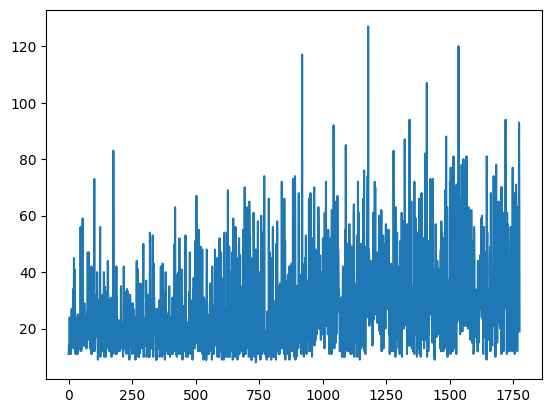

In [121]:
rewards.plot()

In [122]:
msf.epsilon

0.05

<Axes: >

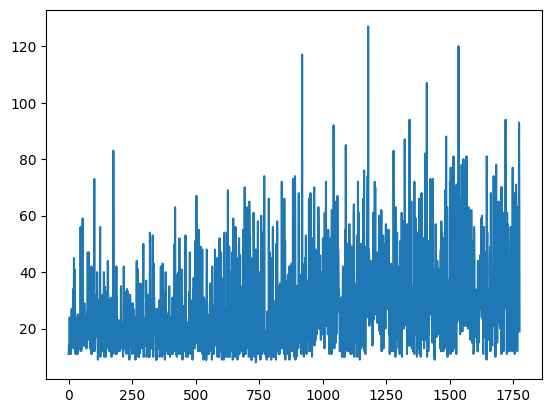

In [123]:
rewards.plot()

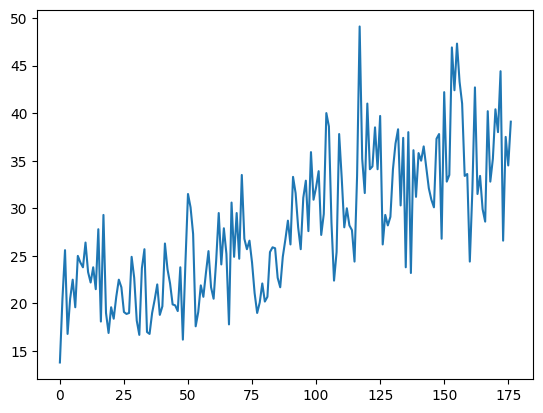

In [126]:
if len(rewards) >= 100:
    means = np.mean(rewards[:-6].to_numpy().reshape(-1, 10), axis=1)
    plt.plot(means)

In [ ]:
if len(rewards) >= 100:
    loss_means = np.mean(loss[:-8].to_numpy().reshape(-1, 10), axis=1)
    plt.plot(loss_means)

In [21]:
import matplotlib.pyplot as plt

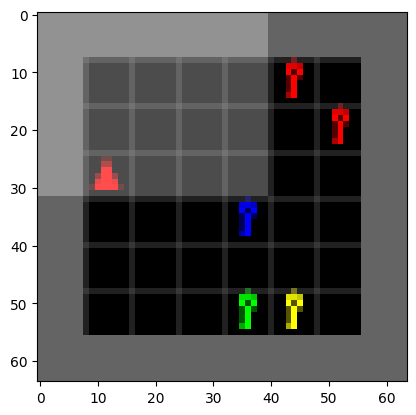

In [110]:
plt.imshow(image)

# N-Step Q-learning

In [25]:
class MSFA_NStep:
    """
    Modular Successor Feature Approximator Agent
    """
    def __init__(self, source_tasks, target_tasks, vector_tasks, config):
        self.source_tasks = source_tasks
        self.target_tasks = target_tasks
        self.vector_tasks = vector_tasks # This is for the USFA heads.
        self.logger = Logger('')
        
        # self.n_acton
        self.epsilon = config.epsilon
        self.min_epsilon = 0.05
        
        self.gym_legacy = config.gym_legacy
        self.n_batch = config.batch_size
        self.n_training_steps = config.n_training_steps
        self.evaluation_n_training_steps = config.evaluation_n_training_steps
        self.log_performance_n_training_steps = config.log_performance_n_training_steps
        
        # config DQN
        self.n_step_q_learning = config.n_step_q_learning
        if config.n_step_q_learning > 0:
            self.replay_buffer = NStepQLearningMemory(config)
        
        # Task configuration
        first_task = self.source_tasks[0]
        self.task_embedder = OAREmbedder(first_task.action_space.n)
        
        # Initialise models DQN test
        # self.msf = RecurrentNetwork()
        self.loss = torch.nn.HuberLoss()
        self.target_network = DQNModel(first_task.action_space.n)
        self.policy_network = DQNModel(first_task.action_space.n)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=config.learning_rate)
        self.gamma = to_tensor(config.gamma) # Convert to tensor since beginning
        
        self.use_target_soft_update = config.use_target_soft_update
        self.target_update_tau = config.target_update_tau
        self.n_steps_update_target_model = config.n_steps_update_target_model # If soft update is True this is not needed.

        self.policy_network.train()
        self.target_network.eval()
        
        # Debug purposes
        self.debug_gradients = False
        self.current_state_from_render = False
    
    def process_current_state(self, obs, env):
        
        if self.current_state_from_render:
            # Get image from observations
            current_obs = {'image': cv2.resize(env.render(), [64,64])} # For CARTPOLE
            current_state = to_tensor(current_obs['image']).unsqueeze(0) # B H W C
        else:
            current_obs = obs
            current_state = to_tensor(current_obs['image']).unsqueeze(0)
        
        current_state = current_state.permute([0,3,1,2]) # B C H W
        
        return current_obs, current_state
    
    def execute(self):
        # reset agent
        
        # Train agent with all source tasks
        for source_task_id, env in enumerate(self.source_tasks):
            ### Reset Environment
            if self.gym_legacy:
                obs = env.reset()  # Reset environment
            else:
                obs, info = env.reset()
                        
            current_obs, current_state = self.process_current_state(obs, env)
            
            
            # episode rewards
            # reset_episode
            self.episode_rewards = torch.tensor(0.0, device=device)
            self.episode_loss = torch.tensor(0.0, device=device)
            self.n_episode = 0
            
            for training_step in range(self.n_training_steps):
                
                #########################################################
                ### Training in source tasks
                ### epsilon greedy
                with torch.no_grad():
                    if random.random() <= self.epsilon:
                        current_action = env.action_space.sample()
                    else:
                        current_action = torch.argmax(self.policy_network(current_state)).item()

                if self.gym_legacy: # Step the environoment with the sampled random action
                    next_obs, reward, terminated, info = env.step(current_action)
                else:
                    next_obs, reward, terminated, truncated, info = env.step(current_action)
                
                # Embedded vector
                # embedded_vector = self.task_embedder(a, obs, reward)
                next_obs, next_state = self.process_current_state(next_obs, env)
                
                self.replay_buffer.append(current_state, current_action, to_tensor(reward), next_state, self.gamma, to_tensor(terminated), 0)
                
                # Go to the next state
                current_obs = next_obs
                current_state = next_state
                
                # Replay buffers or slide window for N-Step Q learning
                accum_loss = torch.tensor(0, device=device)
                
                # Any n_step_q_learning
                if training_step % 1 == 0:
                
                    replay_buffer = self.replay_buffer.replay()

                    if replay_buffer is not None:

                        # Update models in DQN style
                        states, actions, rewards, next_states, gammas, terminated_masks, _ = replay_buffer
                        
                        # next actions? For the Q value network we should have the next action
                                                
                        # For periodic environments
                        with torch.no_grad():
                            # Terminated states have 0 value
                            gammas = gammas ** (self.n_step_q_learning)
                            target_q_values = rewards + (gammas * (1 - terminated_masks)) * torch.max(self.target_network(next_states), axis=1, keepdim=True).values

                        current_q_values = self.policy_network(states).gather(1, torch.tensor(actions, dtype=torch.int64)) # Get from the dimension 1 the a position
                        
                        accum_loss = self.loss(target_q_values, current_q_values)
                        
                        self.optimizer.zero_grad()
                        accum_loss.backward()
                        self.optimizer.step()
                                                
                        # For debugging purposes
                        if self.debug_gradients:
                            accum_norm = 0
                            accum_norm_params = 0
                            for param in self.policy_network.parameters():
                                accum_norm += torch.norm(param.grad)
                                accum_norm_params += torch.norm(param.data)
                                
                            print('after', training_step, accum_norm, accum_norm_params)
                
                # Accumulate episode rewards and losses
                self.episode_rewards += to_tensor(reward)
                self.episode_loss += to_tensor(accum_loss)
                
                #########################################################
                ### Update target network. Using soft-update or hard-update
                if self.use_target_soft_update:
                    # if soft update the params based on DPPG
                    for target_param, source_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
                        target_param.data.copy_((self.target_update_tau * source_param.data) + (1 - self.target_update_tau) * target_param.data)
                else:
                    if training_step % self.n_steps_update_target_model == 0:
                        with torch.no_grad():
                            #self.target_network.load_state_dict(self.policy_network.state_dict())
                            for target_param, source_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
                                target_param.data.copy_(source_param.data)

                #########################################################
                ### Evaluation in target tasks
                if training_step % self.evaluation_n_training_steps == 0:
                    #print('Evaluation in training', training_step)
                    pass
                
                #########################################################
                ### Logging source and target tasks performance
                # TODO Be careful with the logger. It can happen that if the log_performance in training steps does not have values in loss it can be 0 always.
                # Check with n-step QLearning
                #if training_step % self.log_performance_n_training_steps == 0:
                    #self.epsilon = self.epsilon * 0.99                
                    #self.logger.log_agent_performance(source_task_id, reward, training_step, accum_loss.detach().cpu())
                
                # Episodic environments log performance
                self.epsilon = max(self.epsilon * 0.9999, self.min_epsilon) # Have a minimum of exploration. Be aware epsilon.
                
                if terminated or truncated:
                    self.n_episode += 1
                    
                    self.logger.log_agent_performance(source_task_id, self.episode_rewards, self.n_episode, self.episode_loss.detach().cpu())
                    
                    current_obs, _ = env.reset()
                    current_obs, current_state = self.process_current_state(current_obs, env)
                    
                    self.episode_rewards = torch.tensor(0.0)
                    self.episode_loss = torch.tensor(0.0)

In [26]:
import gymnasium as gym
from gym.envs.classic_control import CartPoleEnv
from gym.wrappers import ResizeObservation
import cv2
import matplotlib.pyplot as plt
import time

training_envs = [CartPoleEnv(render_mode='rgb_array')]

config = DQNAgentConfig()
config.gym_legacy = False

msf = MSFA_NStep(training_envs, [], [], config)
msf.execute()

for env in training_envs:
    env.close()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [10]:
import gymnasium as gym
from minigrid.wrappers import RGBImgObsWrapper
from envs.babyai.gotoavoid import PickupAndAvoid

# First is 
vector_to_reward = [1,0,0,0]

training_envs = [RGBImgObsWrapper(PickupAndAvoid(5, vector_to_reward, render_mode='human'))]
testing_envs = [PickupAndAvoid(5, vector_to_reward, render_mode='human')]

# config = DQNAgentConfig()
# config.gym_legacy = False

# msf = MSFA_NStep(training_envs, testing_envs, vector_to_reward, config)
# msf.execute()

for env in training_envs:
    env.reset()
    env.render()
    
    # env.close()

In [1]:
errors = msf.logger.load_text()[1]
mean = []

init = 0
window = 5

for i in range(len(errors) // window):
    mean.append(np.mean(errors[init: init + window]))
    init = init + window

pd.DataFrame(mean).plot()

NameError: name 'msf' is not defined

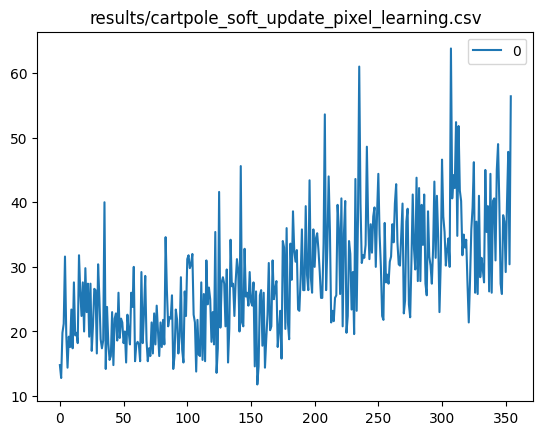

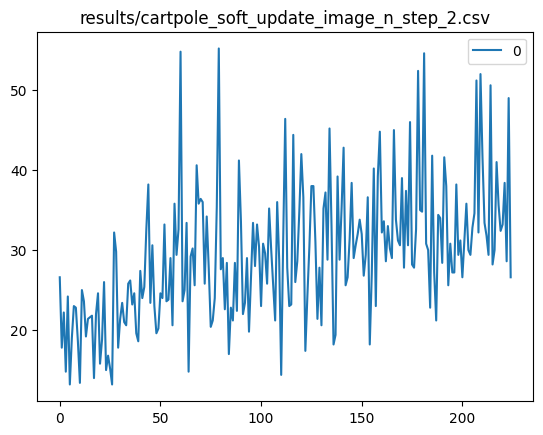

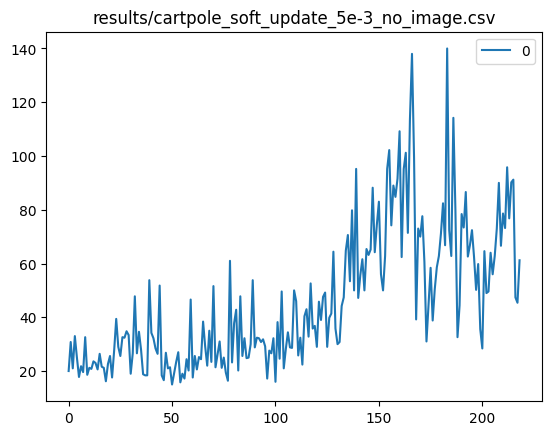

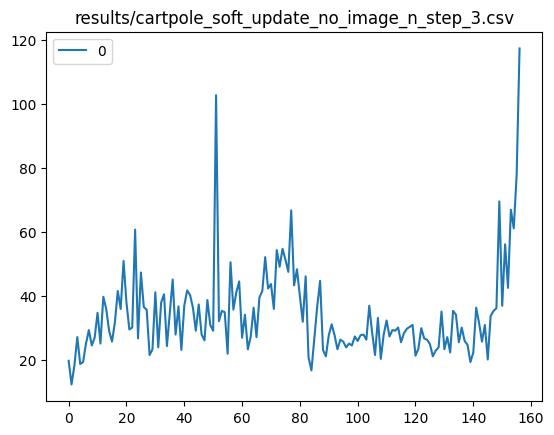

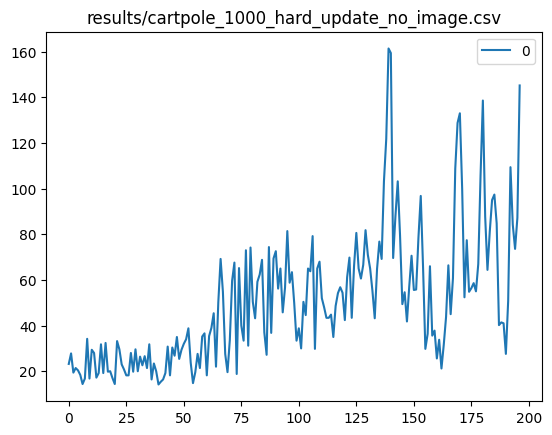

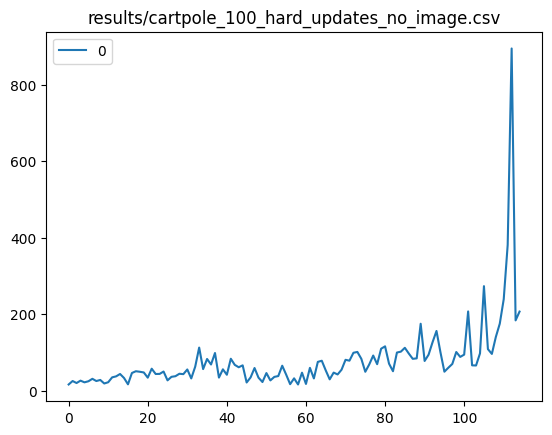

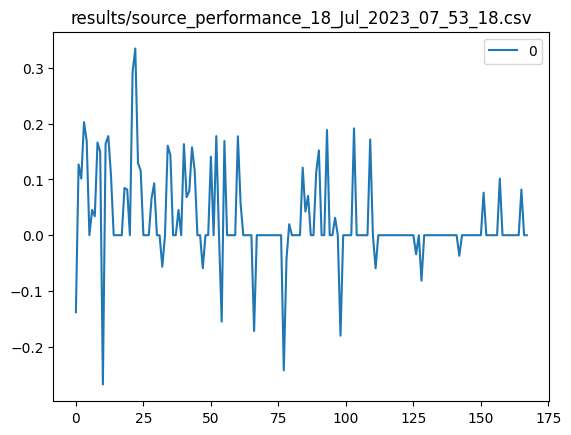

In [49]:
import os

results_path = 'results'

for path in os.listdir(results_path):
    mean = []
    init = 0
    window = 5
    
    # check if current path is a file
    current_path = os.path.join(results_path, path)
    if os.path.isfile(current_path):
        rewards_last = pd.DataFrame(np.loadtxt(current_path, delimiter=','))[1]
        
        for i in range(len(rewards_last) // window):
            mean.append(np.mean(rewards_last[init: init + window]))
            init = init + window
        pd.DataFrame(mean).plot(title=current_path)

# N-Step Q-Learning Successor Features

In [18]:
class MSFA_SF_NStep:
    """
    Modular Successor Feature Approximator Agent
    """
    def __init__(self, source_tasks, target_tasks, vector_tasks, config):
        self.source_tasks = source_tasks
        self.target_tasks = target_tasks
        self.vector_tasks = vector_tasks # This is for the USFA heads.
        self.logger = Logger('')
        
        # self.n_acton
        self.epsilon = config.epsilon
        self.min_epsilon = 0.05
        
        self.gym_legacy = config.gym_legacy
        self.n_batch = config.batch_size
        self.n_training_steps = config.n_training_steps
        self.evaluation_n_training_steps = config.evaluation_n_training_steps
        self.log_performance_n_training_steps = config.log_performance_n_training_steps
        self.episode_length = config.episode_length
        
        # config DQN
        self.n_step_q_learning = config.n_step_q_learning
        if config.n_step_q_learning > 0:
            # self.replay_buffer = NStepQLearningMemory(config)
            self.replay_buffer = RecurrentNStepQLearningMemory(config)
        
        # Task configuration
        first_task = self.source_tasks[0]
        self.task_embedder = OAREmbedder(first_task.action_space.n)
        
        # Initialise models DQN test
        # self.msf = RecurrentNetwork()
        self.loss = torch.nn.HuberLoss()
        # self.target_network = DQN_SF_Model()
        # self.policy_network = DQN_SF_Model()
        
        self.target_network = DQN_USFA_Model().to(device)
        self.policy_network = DQN_USFA_Model().to(device)
        
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=config.learning_rate)
        self.gamma = to_tensor(config.gamma) # Convert to tensor since beginning
        
        self.use_target_soft_update = config.use_target_soft_update
        self.target_update_tau = config.target_update_tau
        self.n_steps_update_target_model = config.n_steps_update_target_model # If soft update is True this is not needed.

        self.policy_network.train()
        self.target_network.eval()
        
        # Debug purposes
        self.debug_gradients = False
        self.current_state_from_render = False
    
    def process_current_state(self, obs, env):
        
        if isinstance(obs, tuple):
            obs, *_ = obs
        
        if self.current_state_from_render:
            # Get image from observations render
            current_obs = {'image': cv2.resize(env.render(), [64,64])} # For CARTPOLE
            current_state = to_tensor(current_obs['image']).unsqueeze(0) # B H W C
        else:
            # Get image from observations using 
            current_obs = obs
            current_state = to_tensor(current_obs['image']).unsqueeze(0)
        
        current_state = current_state.permute([0,3,1,2]) # B C H W
        
        return current_obs, current_state
    
    def execute(self):
        # reset agent
        
        # Train agent with all source tasks
        for source_task_id, env in enumerate(self.source_tasks):
            ### Reset Environment
            obs = env.reset()
            # env.reset() # Do not store obs for USFA
            
            current_obs, current_state = self.process_current_state(obs, env)            
            # current_obs = None
            # current_state = None
            current_action = None
            
            # episode rewards
            # reset_episode
            self.episode_rewards = torch.tensor(0.0, device=device)
            self.episode_loss = torch.tensor(0.0, device=device)
            self.episode_q_loss = torch.tensor(0.0, device=device)
            self.episode_psi_loss = torch.tensor(0.0, device=device)
            self.n_episode = 0
            
            # Replay buffers or slide window for N-Step Q learning
            accum_loss = torch.tensor(0, device=device)
            
            for training_step in range(self.n_training_steps):
                
                #########################################################
                ### Training in source tasks
                ### epsilon greedy
                with torch.no_grad():
                    # Be aware. USFA needs the previous action taken. If current action is None is an initial state
                    # we need to sample the action.
                    if (current_action is None) or (random.random() <= self.epsilon):
                        current_action = env.action_space.sample()
                    else:
                        # According to Carvalho they fit the successor feature using the vector_to_reward or reward mapper
                        # USE GPI in target tasks
                        # Here current_action was the previous action that leads to the current state
                        # USFA needs previous action.
                        current_sf, current_q_value_sf  = self.policy_network(current_state, env.vector_to_reward, current_action)
                        # Perform GPI on z_samples according to Borsa2020
                        # From [n_batch, d_z_samples, n_actions ]
                        max_q_value_sf = torch.max(current_q_value_sf, axis=1).values # [n_batch, n_actions ]
                        current_action = torch.argmax(max_q_value_sf, dim=1).item() # [n_batch, n_actions ]
                

                if self.gym_legacy: # Step the environoment with the sampled random action
                    next_obs, reward, terminated, info = env.step(current_action)
                else:
                    next_obs, reward, terminated, truncated, info = env.step(current_action)

                # Embedded vector
                # embedded_vector = self.task_embedder(a, obs, reward)
                next_obs, next_state = self.process_current_state(next_obs, env)
                
                # Oracle phi
                phi_value = info['features'] # If phi is fixed is coming from Env.
                
                # Only store if current state
                self.replay_buffer.append(current_state, current_action, to_tensor(reward), next_state, to_tensor(self.gamma), to_tensor(terminated), to_tensor(phi_value))
                
                # Go to the next state
                current_obs = next_obs
                current_state = next_state
                previous_action = current_action
                
                # Any n_step_q_learning
                if training_step % 100 == 0:
                
                    replay_buffer = self.replay_buffer.replay()

                    if replay_buffer is not None:

                        # Update models in DQN style
                        states, actions, rewards, next_states, gammas, terminated_masks, phi = replay_buffer
                        
                        # Get the first transitions from n_trace sequences
                        actions = actions[:,0,:] # [n_batch, n_actions]
                        rewards = rewards[:,0,:]
                        gammas = gammas[:,0,:]
                        terminated_masks = terminated_masks[:,0,:]
                        phi = phi[:,0,:]
                        
                        # next actions? For the Q value network we should have the next action
                                                
                        # For periodic environments
                        with torch.no_grad():
                            # Terminated states have 0 value
                            gammas = gammas ** (self.n_step_q_learning)
                            target_sf, target_q_value_sf = self.target_network(next_states, env.vector_to_reward, actions, 'train') # USFA needs states and actions?
                            
                            # Computa target q values
                            # [n_batch, d_z_samples, n_actions]
                            max_target_q_value_sf = torch.max(target_q_value_sf, axis=1, keepdim=True).values  # Perform GPI over z_samples
                            next_actions = torch.argmax(max_target_q_value_sf, axis=2, keepdim=True) # GPI to get actions
                            max_target_q_value_sf = max_target_q_value_sf.gather(2, next_actions)
                            target_q_values = rewards + (gammas * (1 - terminated_masks)) * max_target_q_value_sf.reshape(max_target_q_value_sf.shape[0], -1) # Remove last dimension no needed
                            
                            # Compute target successor features
                            next_actions_sf = next_actions.unsqueeze(-1).repeat(1,30,1,4)
                            
                            target_sf_values = phi.unsqueeze(1).unsqueeze(1) + (gammas.unsqueeze(1).unsqueeze(1) * (1 - terminated_masks.unsqueeze(1).unsqueeze(1)) * target_sf.gather(2, next_actions_sf)) # Remember the dimension
                        
                        
                        current_sf, current_q_value_sf = self.policy_network(states, env.vector_to_reward, actions,  'train')
                        #  [n_batch, d_z_sample, n_actions, d_features]
                        # current q value
                        actions = to_tensor(actions).to(dtype=torch.int64).unsqueeze(1).repeat(1,30,1) # Same dimensions in the samples. In this case 30 is the number of z samples.
                        current_q_value_sf = current_q_value_sf.gather(2, actions).max(axis=1).values # Get from the dimension 2 the a position                        
                        
                        # Current sf
                        current_actions_sf = actions.unsqueeze(-1).repeat(1,1,1,4) # Add features dimension in actions.
                        current_sf = current_sf.gather(2, current_actions_sf)
                        
                        # First loss Q-Loss
                        q_loss = self.loss(target_q_values, current_q_value_sf)
                        psi_loss = self.loss(target_sf_values, current_sf)
                        phi_loss = self.loss(to_tensor(torch.tensor(0, dtype=torch.float64)), to_tensor(torch.tensor(0, dtype=torch.float64)))
                        
                        accum_loss = 1.0 * q_loss + 0.5 * psi_loss + 0.5 * phi_loss
                        
                        self.optimizer.zero_grad()
                        accum_loss.backward()
                        self.optimizer.step()
                        
                        # Add episode loss
                        self.episode_loss += to_tensor(accum_loss)
                        self.episode_q_loss += to_tensor(q_loss)
                                                
                        # For debugging purposes
                        if self.debug_gradients:
                            accum_norm = 0
                            accum_norm_params = 0
                            for param in self.policy_network.parameters():
                                accum_norm += torch.norm(param.grad)
                                accum_norm_params += torch.norm(param.data)
                                
                            print('after', training_step, accum_norm, accum_norm_params)
                            
                            
                        # free memory
                        torch.cuda.empty_cache()
                
                # Accumulate episode rewards and losses
                self.episode_rewards += to_tensor(reward)                
                
                #########################################################
                ### Update target network. Using soft-update or hard-update
                if self.use_target_soft_update:
                    # if soft update the params based on DPPG
                    for target_param, source_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
                        target_param.data.copy_((self.target_update_tau * source_param.data) + (1 - self.target_update_tau) * target_param.data)
                else:
                    if training_step % self.n_steps_update_target_model == 0:
                        with torch.no_grad():
                            #self.target_network.load_state_dict(self.policy_network.state_dict())
                            for target_param, source_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
                                target_param.data.copy_(source_param.data)

                #########################################################
                ### Evaluation in target tasks
                if training_step % (self.evaluation_n_training_steps * 1_000) == 0:                    
                    print('Evaluation in training', training_step)
                    
                    # TODO To finish GPI
                    # Copy all reward to vectors. Compute the Q value for each training reward vector
                    # Compute matmul with W_test
                    # torch.max(mat_mul)
                    # argmax dim 1, actions
                
                #########################################################
                ### Logging source and target tasks performance
                # TODO Be careful with the logger. It can happen that if the log_performance in training steps does not have values in loss it can be 0 always.
                # Check with n-step QLearning
                #if training_step % self.log_performance_n_training_steps == 0:
                    #self.epsilon = self.epsilon * 0.99                
                    #self.logger.log_agent_performance(source_task_id, reward, training_step, accum_loss.detach().cpu())
                
                # Episodic environments log performance
                self.epsilon = max(self.epsilon * 0.9999, self.min_epsilon) # Have a minimum of exploration. Be aware epsilon.
                
                if training_step % self.episode_length == 0:
                    self.n_episode += 1
                    
                    self.logger.log_agent_performance(source_task_id, self.episode_rewards.detach().cpu(), self.n_episode, training_step, self.episode_loss.detach().cpu(), self.episode_q_loss.detach().cpu())
                    
                    current_obs, _ = env.reset()
                    current_obs, current_state = self.process_current_state(current_obs, env)
                    current_action = None # reinit action
                    
                    self.episode_rewards = torch.tensor(0.0, device=device)
                    self.episode_loss = torch.tensor(0.0, device=device)
                    self.episode_q_loss = torch.tensor(0.0, device=device)
                    self.episode_psi_loss = torch.tensor(0.0, device=device)

# GoTo Avoid environment

In [19]:
import gymnasium as gym
from minigrid.wrappers import RGBImgObsWrapper
from envs.babyai.gotoavoid import PickupAndAvoid

# First is 
vector_to_reward = to_tensor([1,0,0,0])
number_of_objects = len(vector_to_reward) * 3

training_envs = [RGBImgObsWrapper(PickupAndAvoid(number_of_objects, vector_to_reward))]
testing_envs = [RGBImgObsWrapper(PickupAndAvoid(number_of_objects, to_tensor([0,0,0,1])))]

config = DQNAgentConfig()
config.gym_legacy = False

msf = MSFA_SF_NStep(training_envs, testing_envs, [vector_to_reward], config)
msf.execute()

# for env in training_envs:
#     env.reset()
#     env.render()

# for env in training_envs:
#     env.close()

pygame 2.4.0 (SDL 2.26.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Evaluation in training 0
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size([32, 40, 1]) torch.Size([32, 40, 128])
torch.Size(

OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 1.83 GiB total capacity; 858.39 MiB already allocated; 125.88 MiB free; 964.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [45]:
torch.cuda.empty_cache()

In [39]:
import gymnasium as gym
from minigrid.wrappers import RGBImgObsWrapper
from envs.babyai.gotoavoid import PickupAndAvoid

vector_to_reward = to_tensor([1,0,0,0])
number_of_objects = len(vector_to_reward) * 3
dummy_env = RGBImgObsWrapper(PickupAndAvoid(number_of_objects, vector_to_reward, render_mode='human')) # Number of elements is 3 instances of each type of object

In [40]:
obs, *_ = dummy_env.reset()
image = obs['image']
image = to_tensor(image).unsqueeze(0).permute([0,3,1,2])


for i in range(10_000):
    action = dummy_env.action_space.sample()
    
    obs, reward, terminated, trunc, info = dummy_env.step(action)
    
    if action > 3:
        print('Action', action, 'terminated', terminated, reward)
    
    if terminated:
        print('Reward', reward, vector_to_reward)

Reward tensor(0.) tensor([1., 0., 0., 0.])


KeyboardInterrupt: 

In [43]:
dummy_env.close()

2.0


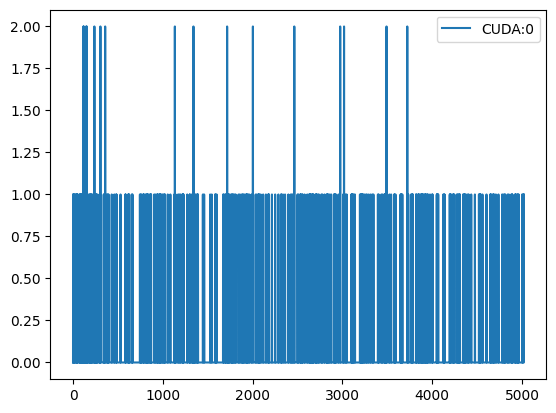

In [16]:
# Plot list of rewards from list
import matplotlib.pyplot as plt

results_paths = [
    # ('22 Aug 2023 - 1', 'results/source_performance_22_Aug_2023_00_38_35.csv'),
    # ('22 Aug 2023 - 2', 'results/source_performance_22_Aug_2023_00_31_06.csv'),
    # ('After errors', 'results/source_performance_22_Aug_2023_05_53_58.csv'),
    ('CUDA:0', 'results/source_performance_22_Aug_2023_06_57_31.csv'),
]

fig, ax = plt.subplots()

for k, path in results_paths:
    data = pd.DataFrame(np.loadtxt(path, delimiter=','))
    # data[1].ewm(1).mean().plot(legend=True)
    data[1].plot(legend=True)
    print(data[1].max())
ax.legend([name for name, _ in results_paths])